<a href="https://colab.research.google.com/github/mdavydenko/tf2demo/blob/master/tf2wrw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# To determine which version you're using:
!pip show tensorflow

# For the current version: 
!pip install --upgrade tensorflow

# For a specific version:
!pip install tensorflow==2.0.0-alpha0 

[  6.13592315  12.2718463   18.40776945  24.54369261  30.67961576
  36.81553891  42.95146206  49.08738521  55.22330836  61.35923152
  67.49515467  73.63107782  79.76700097  85.90292412  92.03884727
  98.17477042 104.31069358 110.44661673 116.58253988 122.71846303
 128.85438618 134.99030933 141.12623249 147.26215564 153.39807879
 159.53400194 165.66992509 171.80584824 177.94177139 184.07769455]


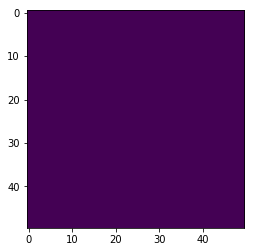

FileNotFoundError: ignored

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

from tensorflow import keras
from datetime import datetime

from tensorflow.linalg import expm, sqrtm

import numpy as np
import matplotlib.pyplot as plt
import math as m

def ricker(f, nf, df=0.001):
    w = df*np.arange(nf,dtype=np.complex64);
    y=w*w/f/f/f/m.sqrt(m.pi)*np.exp(-w*w/f/f)
    return np.transpose(y+1j*0*y)

def Imaging(dx,df,P,Pplu,C):
    nz=C.shape[0]
    nfreq=P.shape[1]
    nx=P.shape[0]
    omega=1+2*m.pi*df*np.arange(0,nfreq)
    grad = np.zeros([nx,nz], dtype=np.complex64)
    Grad  = tf.Variable(grad)
    print(P.shape[0])
    k_x=np.hstack((np.arange(0,(nx/2)),np.arange(-(nx/2),-1)))*2*m.pi/nx/dx
    print(omega.shape)
    [fk_k,fk_f]=np.complex64(np.meshgrid(k_x, omega))
    for iz in range(nz-1):
        kz=tf.math.sqrt(fk_f*fk_f/(C[iz]*C[iz])-fk_k*fk_k)
        P=tf.transpose(tf.signal.ifft(tf.math.conj(tf.exp(-1j*dz*tf.math.conj(kz)))*tf.signal.fft(tf.transpose(P))))
        Grad[:,iz+1].assign(tf.reduce_mean(P*tf.math.conj(tf.squeeze(P_plu[:,iz+1,:])),axis=1))

    return -Grad


#@tf.function
def FWMod(nmod,down,up,dx,df,P,S,Pplu,Pmin,Rup,Rdown,Tup,Tdown,C):
    nz=C.shape[1]

    nfreq=P.shape[0]
    nx=P.shape[1]
    omega=1+2*m.pi*df*np.arange(0,nfreq)

    k_x=np.hstack((np.arange(0,(nx/2)),np.arange(-(nx/2),-1)))*2*m.pi/nx/dx
    x=np.arange(nx)
    [fk_k,fk_f]=np.complex64(np.meshgrid(k_x, omega))
    [x,om]=np.complex64(np.meshgrid(x, omega))
    om=tf.reshape(tf.tile(om,[1,nx]),[nfreq,nx,nx])

    h2dx=np.eye(nx,nx,1,dtype=np.complex64)/dx/dx-2*np.eye(nx,dtype=np.complex64)/dx/dx+np.eye(nx,nx,-1,dtype=np.complex64)/dx/dx
    H2dx = tf.Variable(h2dx)
    H2dx = tf.reshape(tf.tile(H2dx,[nfreq,1]),[nfreq,nx,nx])

    print(om.shape)
    extr=1

    for imod in range(nmod):
        print(imod)
        P=S
        Pp=S
        #with tf.name_scope('rountrip_down'):
        if down:
            print('down')
            for iz in range(nz-1):

                with tf.name_scope('scattering_down_%d_z_%d' % (imod,iz)):
                    P=P+Rdown[:,iz]*Pmin[:,iz,:]+Tup[:,iz]*Pplu[:,iz,:]
                    #P=P+tf.transpose(tf.reshape(tf.tile(Rdown[:,iz],[nfreq]),[nfreq,nx]))*tf.squeeze(Pmin[:,iz,:])+tf.transpose(tf.reshape(tf.tile(Tup[:,iz],[nfreq]),[nfreq,nx]))*tf.squeeze(Pplu[:,iz,:])
                with tf.name_scope('propagation_down_%d_z_%d' % (imod,iz)):
                    if extr==0:
                        kz=tf.math.sqrt(fk_f*fk_f/(C[:,iz])-fk_k*fk_k)
                        P=tf.signal.ifft(tf.exp(-1j*dz*tf.math.conj(kz))*tf.signal.fft(P),name="W-down")
                    if extr==1:
                        H2=om*om*tf.eye(nx,batch_shape=[nfreq],dtype=np.complex64)/C[:,iz]+H2dx
                        W=tf.linalg.expm(-1j*dz*tf.math.conj(tf.linalg.sqrtm(H2)))
                        P=tf.squeeze(tf.matmul(W,tf.reshape(P,[nfreq,nx,1])))

                with tf.name_scope('saving_p_plus_%d_z_%d' % (imod,iz)):
                    Pplu=Pplu[:,iz+1,:].assign(P,name="P_plu")
                    Pp=tf.concat([Pp,P],1,name="Pplu_stack")
                    print(Pp.shape)


        P=0*P
        Pp=tf.reshape(Pp,[nfreq,nz,nx])
        #with tf.name_scope('rountrip_up'):
        if up:
            print('up')

            for iz in reversed(range(1,nz)):
                #print("scat")
                with tf.name_scope('scattering_up_%d_z_%d' % (imod,iz)):
                    P=P+Rup[:,iz]*Pp[:,iz,:]+Tdown[:,iz]*Pmin[:,iz,:]
                    #P=P+tf.transpose(tf.reshape(tf.tile(Rup[:,iz],[nfreq]),[nfreq,nx]))*tf.squeeze(Pplu[:,iz,:])+tf.transpose(tf.reshape(tf.tile(Tdown[:,iz],[nfreq]),[nfreq,nx]))*tf.squeeze(Pmin[:,iz,:])
                    #P=P+tf.transpose(tf.reshape(tf.tile(Rup[:,iz],[nfreq]),[nfreq,nx]))*tf.squeeze(Pp[iz,:,:])+tf.transpose(tf.reshape(tf.tile(Tdown[:,iz],[nfreq]),[nfreq,nx]))*tf.squeeze(Pmin[:,iz,:])
                #print("prop")
                with tf.name_scope('propagation_up_%d_z_%d' %(imod,iz)):
                    if extr==0:
                        kz=tf.math.sqrt(fk_f*fk_f/(C[:,iz])-fk_k*fk_k)
                        P=tf.signal.ifft(tf.exp(-1j*dz*tf.math.conj(kz))*tf.signal.fft(P),name="W-up")
                    if extr==1:
                        H2=om*om*tf.eye(nx,batch_shape=[nfreq],dtype=np.complex64)/C[:,iz]+H2dx
                        W=tf.linalg.expm(-1j*dz*tf.math.conj(tf.linalg.sqrtm(H2)))
                        P=tf.squeeze(tf.matmul(W,tf.reshape(P,[nfreq,nx,1])))
                #print("save")
                with tf.name_scope('saving_p_minus_%d_z_%d' %(imod,iz)):
                    Pmin=Pmin[:,iz-1,:].assign(P,name="P_min")
    return P


#general parameters
ntap=15
nx=50
dx=10
dz=10
nt=256
dt=0.004
nz=50
df=1/nt/dt
mode=0

nfreq=round(nt/2)
nfreq=round(30/df)
ns=1
nmod=3
omega=2*m.pi*df*np.arange(1,nfreq)
print(omega)
#variables
c=1500
vel = c*np.ones([nx,nz], dtype=np.complex64)

rup = np.zeros([nx,nz], dtype=np.complex64)
rdown = np.zeros([nx,nz], dtype=np.complex64)
tup = np.zeros([nx,nz], dtype=np.complex64)
tdown = np.zeros([nx,nz], dtype=np.complex64)

mask = np.ones([nx,nz], dtype=np.complex64)
for iz in range(10):
    mask[:,iz]=0

rtrue = np.zeros([nx,nz], dtype=np.complex64)
ctrue = c*np.ones([nx,nz], dtype=np.complex64)
ctrue=ctrue*ctrue
for ix in range(nx):
    rtrue[ix,10+round(10*ix/nx)]=0.8
    rtrue[ix,40-round(10*ix/nx)]=0.8
    if mode==1:
        ctrue[ix,10+round(10*ix/nx):40-round(10*ix/nx)]=2000




if(mode==1):
    rup=rtrue
    rdown=-rtrue
    tup=rtrue
    tdown=-rtrue
    vel=ctrue




vel=ctrue

plt.imshow(np.abs(vel))
plt.show()

C   =  tf.Variable(vel,name="velocity")
C0   = tf.Variable(vel)

p_plus = np.zeros([nfreq,nx,nz], dtype=np.complex64)
p_minus = np.zeros([nfreq,nx,nz], dtype=np.complex64)
p = np.zeros([nfreq,nx], dtype=np.complex64)
p[:,round(nx/2)]=100*ricker(30,nfreq,df)

P_plu  = tf.Variable(p_plus,name="Pplu")
P_min = tf.Variable(p_minus,name="Pmin")
S = tf.Variable(p,name="wavefield")
P = tf.Variable(p,name="wavefield")

Rup = tf.Variable(rup,name="reflectivity")
Gup = tf.Variable(rup,name="reflectivity")
Rdown = tf.Variable(rdown,name="reflectivity")
Tup = tf.Variable(tup,name="reflectivity")
Tdown = tf.Variable(tdown,name="reflectivity")


Mask = tf.Variable(mask,name="reflectivity")



def loss(Rup,C,Pobs):
  Res = fwmod(R,C) - Pobs
  return tf.reduce_mean(Res*tf.math.conj(Res)),Res

if mode==1:
    #tf.summary.trace_on(graph=True, profiler=True)
    P=FWMod(nmod,1,1,dx,df,P,S,P_plu,P_min,Rup,-Rup,Tup,Tdown,C)
    #with writer.as_default():
    #    tf.summary.trace_export(name="my_func_trace",step=0,profiler_outdir=logdir)

    np.save("pobs",P.numpy())
    plt.imshow(np.fft.irfft(P.numpy(),n=nt,axis=0))
    plt.show()
if mode==0:
    loss_history = []
    for i in range(30):
        pobs=np.load("pobs.npy")
        Pobs=tf.Variable(pobs,name="observed")
        with tf.GradientTape(persistent=True) as tape:
          #tape.watch(C)
          Res=Pobs-FWMod(nmod,1,1,dx,df,P,S,P_plu,P_min,Rup,Rdown,Tup,Tdown,C)
          #Res=Pobs*tf.math.conj(FWMod(nmod,1,1,dx,df,P,S,P_plu,P_min,Rup,Rdown,Tup,Tdown,C))
          #loss=tf.reduce_mean(Res*tf.math.conj(Res))+0.1*tf.reduce_mean((Rup+Rdown)*(Rup+Rdown))
          #pen=0.00001*tf.reduce_mean(tf.math.log(1+tf.math.multiply(Rup,Rup)/0.05/0.05)*tf.math.log(1+tf.math.multiply(Rup,Rup)/0.05/0.05))
          loss=tf.reduce_mean(Res*tf.math.conj(Res))#+pen

        plt.figure(150)
        plt.clf()
        plt.imshow(np.fft.irfft(Res.numpy(),n=nt,axis=0))
        plt.pause(1)
        #gradpen=tape.gradient(pen, Rup)
        #grad_down=tape.gradient(loss, Rdown)
        grad=tape.gradient(loss, Rup)
        gradvel=tape.gradient(loss, C)
        #grad_tup=tape.gradient(loss, Tup)
        #grad_tdown=tape.gradient(loss, Tdown)
        #grad=Imaging(dx,df,Res,P_plu,C)

        loss_value=tf.reduce_mean(Res*tf.math.conj(Res))
        loss_history.append(loss_value.numpy())
        print("Current loss: {:.10f}".format(loss_value))

        #plt.figure(200)
        #plt.clf()
        #plt.imshow(np.transpose(np.real(Grad0.numpy())))

        plt.figure(201)
        plt.clf()
        plt.imshow(np.transpose(np.real(grad.numpy())))
        plt.pause(1)
        plt.figure(2011)
        plt.clf()
        plt.imshow(np.transpose(np.real(gradvel.numpy())))
        plt.pause(1)


        grad=Mask*(grad+tf.math.conj(grad))
        #grad_down=Mask*(grad_down+tf.math.conj(grad_down))
        #grad_tup=Mask*(grad_tup+tf.math.conj(grad_tup))
        #grad_tdown=Mask*(grad_tdown+tf.math.conj(grad_tdown))

        P_min.assign(0*P_min)
        P_plu.assign(0*P_plu)
        Psca=FWMod(1,1,1,dx,df,P,S,P_plu,P_min,grad,Rdown,Tup,Tdown,C)
        P_min.assign(0*P_min)
        P_plu.assign(0*P_plu)

        asum=tf.reduce_mean(Psca*tf.math.conj(Res))+tf.reduce_mean(Res*tf.math.conj(Psca))
        dsum=tf.reduce_mean(Psca*tf.math.conj(Psca))+tf.reduce_mean(Psca*tf.math.conj(Psca))
        Rup.assign_add(asum/dsum*grad)
        Rdown.assign_add(-asum/dsum*grad)
        Tup.assign_add(asum/dsum*grad)
        Tdown.assign_add(-asum/dsum*grad)

        plt.figure(202)
        plt.clf()
        plt.imshow(np.transpose(np.real(Rup.numpy())))
        plt.pause(1)


    plt.show()
